 # IEEE-CIS Fraud Detection Exploratory Data Analysis 

The Purpose of this notebook is to explore the Data in the IEEE-CIS Fraud Detection Kaggle Competition \
https://www.kaggle.com/c/ieee-fraud-detection/data

## Import Required Modules

In [187]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [228]:
# Functions

def distribution_fraud_percent(df: pd.DataFrame, feature: str, target: str, bins: int) -> None:
    fig, ax1 = plt.subplots(figsize=(20, 5)) 

    (n1, bins1, patches1) = plt.hist(df.sort_values(feature)[feature], color='tab:green', bins=bins, alpha=0.5)
    (n2, bins2, patches2) = plt.hist(df.loc[df[target]==1].sort_values(feature)[feature], bins=bins)
    heights1 = pd.Series(n1)
    heights2 = pd.Series(n2)
    heights = pd.concat([heights1, heights2], axis=1)
    heights[f'percent_{target}'] = (heights[1] / (heights[0] + heights[1]))*100
    center = (bins1[1] - bins1[0])/2
    heights['bins'] = (bins1[:-1] + center)

    ax1.set_title(f'{feature} Distribution')
    ax1.set_xlabel(f'{feature}') 
    ax1.set_ylabel('Count', color = 'tab:green') 
    ax1.hist(train.sort_values(feature)[feature], bins=bins, color='tab:green', alpha=0.5)
    ax1.tick_params(axis ='y', labelcolor = 'tab:green') 

    ax2 = ax1.twinx() 

    color = 'tab:red'
    ax2.set_ylabel(f'%{target}', color = 'tab:red') 
    ax2.plot(heights['bins'], heights[f'percent_{target}'], color = 'tab:red', marker='o') 
    ax2.tick_params(axis ='y', labelcolor = 'tab:red')
    
    plt.show()
    
def cat_fraud_percent(df: pd.DataFrame, feature: str, target: str) -> None:
    cat_size = df.groupby(feature).size()
    cat_fraud_size = df.loc[df[target]==1].groupby(feature).size()
    
    print(cat_size)

    cat_fraud_size = pd.DataFrame(cat_fraud_size)
    cat_fraud_size = cat_fraud_size.rename(columns={0: f'count_{target}'})

    cat_size = pd.DataFrame(cat_size)
    cat_size = cat_size.rename(columns={0: 'count'})

    df_merge = cat_size.merge(cat_fraud_size, how='outer', left_index=True, right_index=True)
    df_merge = df_merge.fillna(0.0)
    df_merge[f'percent_{target}'] = \
        (df_merge[f'count_{target}'] / (df_merge[f'count_{target}'] + df_merge['count']))*100

    fig, ax1 = plt.subplots(figsize=(20, 7))

    sns.barplot(x=df_merge.index, y=df_merge['count'], alpha=0.5, ax=ax1)
    ax1.tick_params(labelrotation=90)

    ax1.set_title(f'{feature}')

    ax2 = ax1.twinx()

    sns.lineplot(x=np.arange(0,len(df_merge.index)), y=df_merge[f'percent_{target}'], marker='o', ax=ax2)
    ax2.tick_params(labelrotation=90)
    
    plt.show()
    
def size_and_percentage(df, feature):
    feature_size = df.groupby(f'{feature}', dropna=False).size().sort_values(ascending=False)
    feature_size = pd.DataFrame(feature_size)
    feature_size.rename(columns={0: 'size'}, inplace=True)
    total = feature_size['size'].sum()
    feature_size['percentage'] = (feature_size['size']/total)*100
    return feature_size

def corr_plot(features: list, title: str) -> None:
    plt.figure(figsize=(15, 15))
    sns.heatmap(train[features].corr(), cmap="YlGnBu", annot=True, center=0.0)
    plt.title(title)
    plt.show()
    
def reduce_groups(df: pd.DataFrame, groups: list) -> list:
    useful_features = []
    for g_lst in groups:
        max_vals = 0
        feature = g_lst[0]
        for g in g_lst:
            num_values = df[g].nunique()
            if num_values>max_vals:
                max_vals = num_values
                feature = g
        useful_features.append(feature)
    return useful_features

## Load the Dataset

In [96]:
FOLDER_PATH = 'data'
train_identity = pd.read_csv(f'{FOLDER_PATH}/train_identity.csv')
train_transaction = pd.read_csv(f'{FOLDER_PATH}/train_transaction.csv')
test_identity = pd.read_csv(f'{FOLDER_PATH}/test_identity.csv')
test_transaction = pd.read_csv(f'{FOLDER_PATH}/test_transaction.csv')

In [97]:
# merge the testing and training data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [98]:
print(f'Transaction df shape: {train_transaction.shape}')
train_transaction.head()

Transaction df shape: (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
print(f'Identity df shape: {train_identity.shape}')
train_identity.head()

Identity df shape: (144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [100]:
del train_identity, train_transaction, test_identity, test_transaction

## Exploratory Data Analysis Start

### NAN Analysis

In [101]:
print(f'Train Columns w/ missing data: {train.isna().any().sum()}')

Train Columns w/ missing data: 414


***NAN Count Analysis*** 
* Analyze how many values are missing and which columns have the same number of values missing.
* Having the same amount of missing values between features could indicate that the same indexes are missing the values for both features

In [102]:
missing_values = train.isnull().sum()

missing_dict = {}
for index, value in missing_values.items():
    if value in missing_dict.keys():
        missing_dict[value].append(index)
    else:
        missing_dict[value] = [index]
missing_dict
for key, value in missing_dict.items():
    print(f'############### Missing {key} Values ###############')
    print(value)

############### Missing 0 Values ###############
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
############### Missing 8933 Values ###############
['card2']
############### Missing 1565 Values ###############
['card3']
############### Missing 1577 Values ###############
['card4']
############### Missing 4259 Values ###############
['card5']
############### Missing 1571 Values ###############
['card6']
############### Missing 65706 Values ###############
['addr1', 'addr2']
############### Missing 352271 Values ###############
['dist1']
############### Missing 552913 Values ###############
['dist2']
############### Missing 94456 Values ###############
['P_emaildomain']
############### Missing 453249 Values ###############
['R_emaildomain']
############### Missing 1269 Values ###############
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 

In [103]:
total_cells = np.product(train.shape)
missing_count = missing_values.sum()
print(f'{total_cells/missing_count: .2f}% mising data')

 2.22% mising data


In [104]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


### isFraud Analysis

In [106]:
fraud_count = pd.DataFrame(train.isFraud.value_counts())
fraud_count = fraud_count.reset_index()
print(fraud_count)
no_fraud = fraud_count['isFraud'][0]
fraud = fraud_count['isFraud'][1]
print(f'Fraud Percentage: {(fraud / (no_fraud + fraud)) * 100: .2f}%')

   index  isFraud
0      0   569877
1      1    20663
Fraud Percentage:  3.50%


<Figure size 1152x432 with 0 Axes>

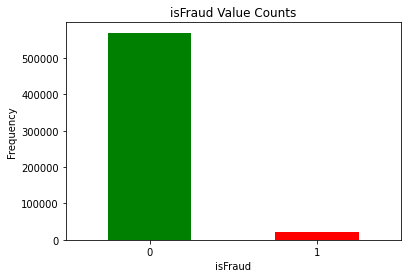

In [107]:
plt.figure(figsize=(16,6))
fraud_count.plot(x='index', y='isFraud', kind='bar', legend=False, color=['green', 'red'], rot=0)
plt.xlabel('isFraud')
plt.ylabel('Frequency')
plt.title('isFraud Value Counts')
plt.show()

Highly imbalanced dataset. Only 3.5% of transactions are fraud. We will need to use an imbalanced dataset technique to properly train the data set.

In [117]:
train_corr = train.corr()['isFraud']
print(train_corr[:15])

TransactionID     0.014166
isFraud           1.000000
TransactionDT     0.013103
TransactionAmt    0.011320
card1            -0.013640
card2             0.003388
card3             0.154151
card5            -0.033580
addr1             0.005596
addr2            -0.030387
dist1             0.021522
dist2            -0.019054
C1                0.030570
C2                0.037229
C3               -0.006833
Name: isFraud, dtype: float64


In [121]:
train_corr.sort_values(ascending=False)[1:15]

V257    0.383060
V246    0.366878
V244    0.364129
V242    0.360590
V201    0.328005
V200    0.318783
V189    0.308219
V188    0.303582
V258    0.297151
V45     0.281832
V158    0.278066
V156    0.275952
V149    0.273282
V228    0.268861
Name: isFraud, dtype: float64

### Transaction Amt Analysis

In [122]:
train.TransactionAmt.describe()

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

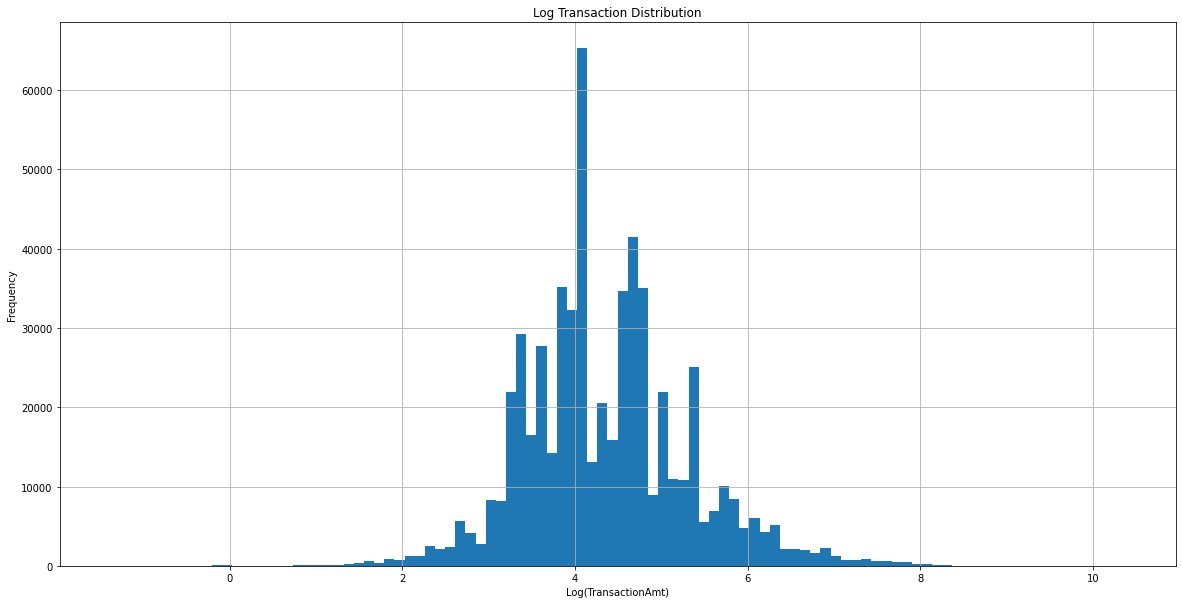

In [123]:
plt.figure(figsize=(20,10))
train['log_trans_amt'] = np.log(train['TransactionAmt'])
train['log_trans_amt'].hist(bins=100)
plt.xlabel('Log(TransactionAmt)')
plt.ylabel('Frequency')
plt.title('Log Transaction Distribution')

plt.show()

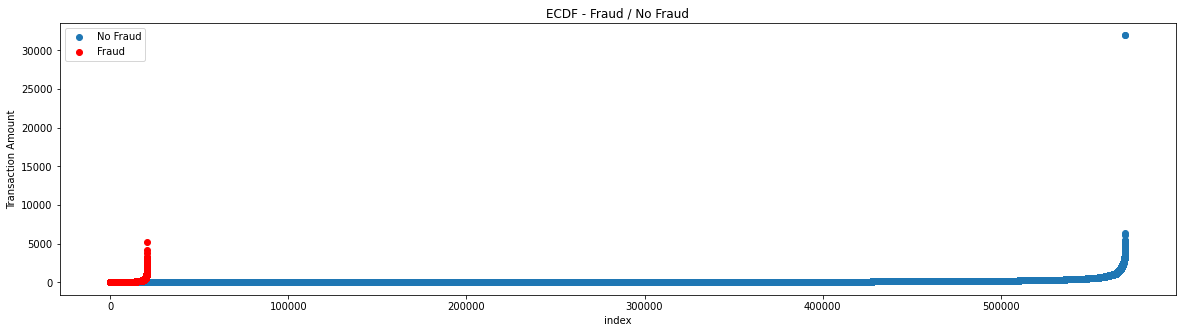

In [124]:
plt.figure(figsize=(20,5))
plt.scatter(train.loc[train['isFraud'] == 0].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 0][['TransactionAmt']].sort_values('TransactionAmt'), label='No Fraud')
plt.scatter(train.loc[train['isFraud'] == 1].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 1][['TransactionAmt']].sort_values('TransactionAmt'), color='red', label = 'Fraud')
plt.xlabel('index')
plt.ylabel('Transaction Amount')
plt.title('ECDF - Fraud / No Fraud')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ECDF - Fraud')

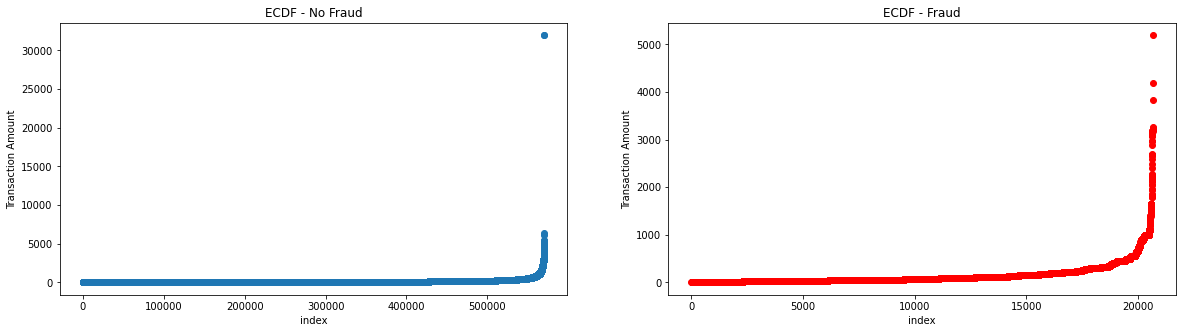

In [125]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ax1.scatter(train.loc[train['isFraud'] == 0].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 0][['TransactionAmt']].sort_values('TransactionAmt'), label='No Fraud')
ax1.set_xlabel('index')
ax1.set_ylabel('Transaction Amount')
ax1.set_title('ECDF - No Fraud')

ax2.scatter(train.loc[train['isFraud'] == 1].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 1][['TransactionAmt']].sort_values('TransactionAmt'), color='red', label = 'Fraud')
ax2.set_xlabel('index')
ax2.set_ylabel('Transaction Amount')
ax2.set_title('ECDF - Fraud')

This demonstrates that most fraud has low Transaction amounts. Similar ECDF shape to the no fraud shape

### Quantiles of Fraud and No Fraud Transactions

In [127]:
print('Quantiles of Fraud')
print(train.loc[train['isFraud'] == 1]['TransactionAmt'].quantile([0.01, 0.1, 0.24, 0.5, 0.75, 0.9]).reset_index())

Quantiles of Fraud
   index  TransactionAmt
0   0.01         6.74096
1   0.10        18.93600
2   0.24        34.00000
3   0.50        75.00000
4   0.75       161.00000
5   0.90       335.00000


In [128]:
print('Quantiles of No Fraud')
print(train.loc[train['isFraud'] == 0]['TransactionAmt'].quantile([0.01, 0.1, 0.24, 0.5, 0.75, 0.9]).reset_index())

Quantiles of No Fraud
   index  TransactionAmt
0   0.01         9.51288
1   0.10        26.31000
2   0.24        40.95000
3   0.50        68.50000
4   0.75       120.00000
5   0.90       267.11200


#### TansactionAMT Outliers

In [21]:
amt_outliers = detect_outlier(train['TransactionAmt'])
print(f'TransactionAmt Outlier Count: {len(amt_outliers)}')
non_outlier_cnt = len(train['TransactionAmt'])-len(amt_outliers)
print(f'TransactionAmt Non-Outlier Count: {non_outlier_cnt}')

TransactionAmt Outlier Count: 10093
TransactionAmt Non-Outlier Count: 580447


### Product Feature

ProductCD: product code, the product for each transaction \
Explore the ProductCD Feature (part of the transactions data)

ProductCD
C     68519
H     33024
R     37699
S     11628
W    439670
dtype: int64


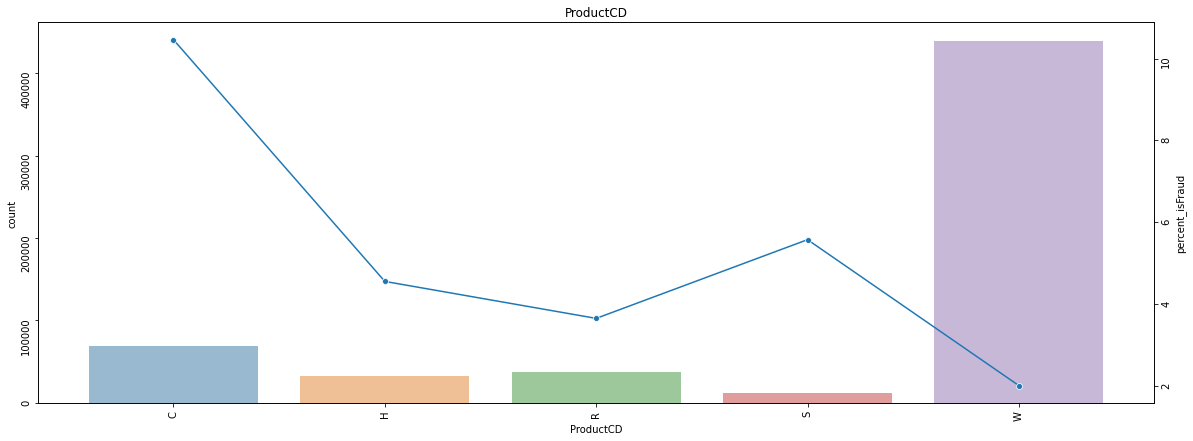

In [169]:
cat_fraud_percent(df=train, 
                  feature='ProductCD',
                  target='isFraud')

C and W are the most common fraud cases. W is the most common overall ProductCD so it makes sense that it will also be a common fraud case. C only accounts for 11% of the total ProductCD, but it accounts for around 40% of the total fraud cases.

### Card Feature

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc. \
(part of the transactions data)

In [131]:
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
train[card_features].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


All of these feautres identify the card information that is used for the transaction

***Debit vs Credit***

Text(0.5, 1.0, 'Fraud Card6')

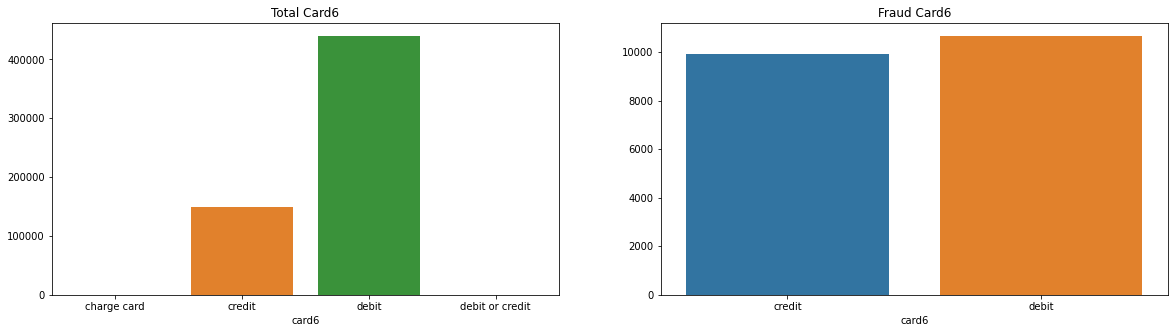

In [154]:
f, axes = plt.subplots(1, 2, figsize=(20,5))

card6_size = train.groupby('card6').size()
card6_fraud_size = train.loc[train['isFraud']==1].groupby('card6').size()

sns.barplot(x=card6_size.index, y=card6_size.values, ax=axes[0])
sns.barplot(x=card6_fraud_size.index, y=card6_fraud_size.values, ax=axes[1])

axes[0].set_title('Total Card6')
axes[1].set_title('Fraud Card6')

***Card Company***

card4
american express      8328
discover              6651
mastercard          189217
visa                384767
dtype: int64


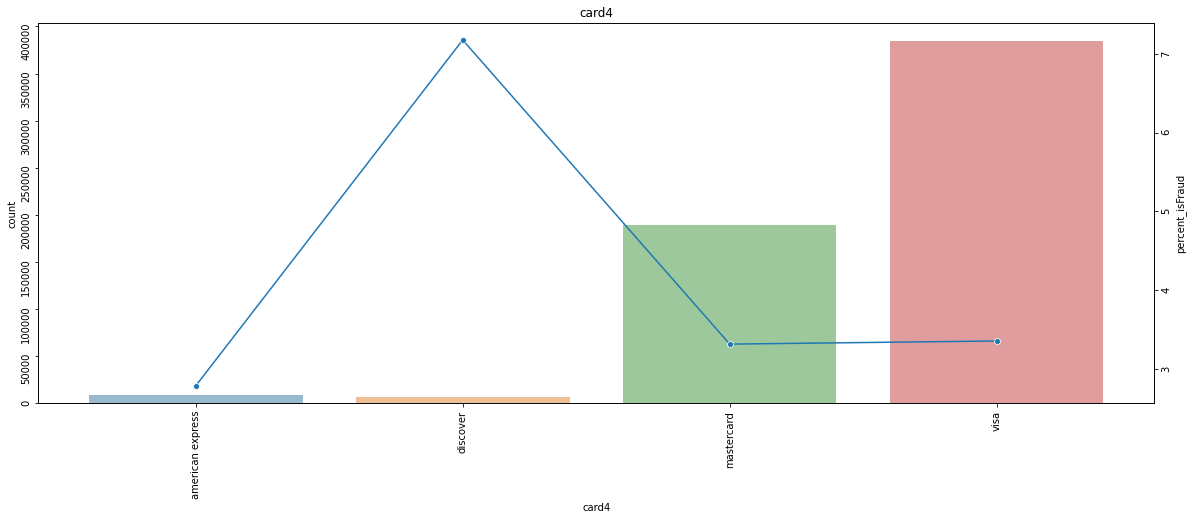

In [170]:
cat_fraud_percent(df=train, 
                  feature='card4',
                  target='isFraud')

Discover seems to have a higher likelyhood of fraud compared to the others

***Card 1, 2, 3, and 5 Distributions***

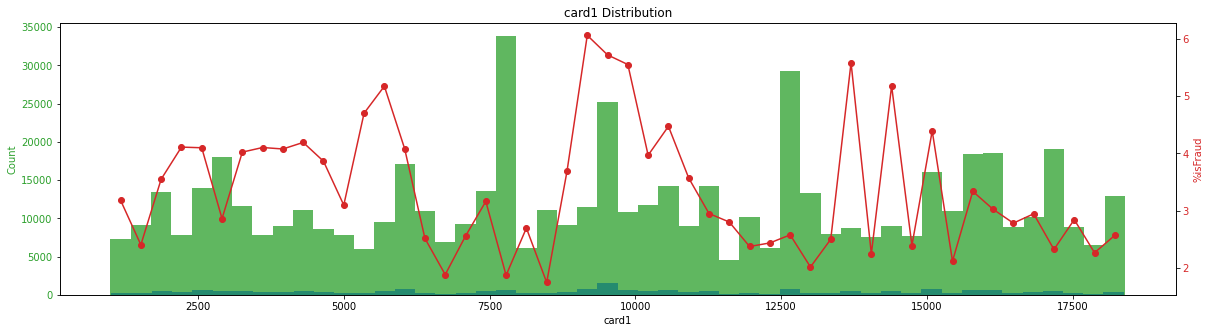

In [158]:
distribution_fraud_percent(df=train,
                           feature='card1',
                           target='isFraud',
                           bins=50)

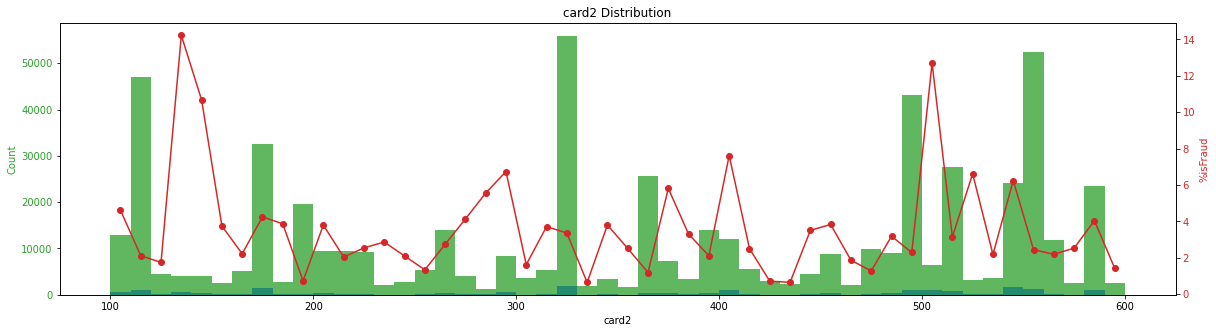

In [159]:
distribution_fraud_percent(df=train,
                           feature='card2',
                           target='isFraud',
                           bins=50)

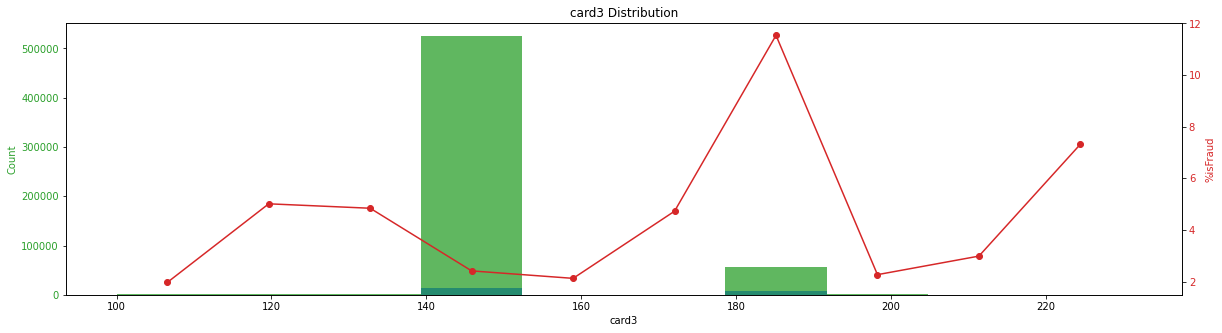

In [160]:
distribution_fraud_percent(df=train,
                           feature='card3',
                           target='isFraud',
                           bins=10)

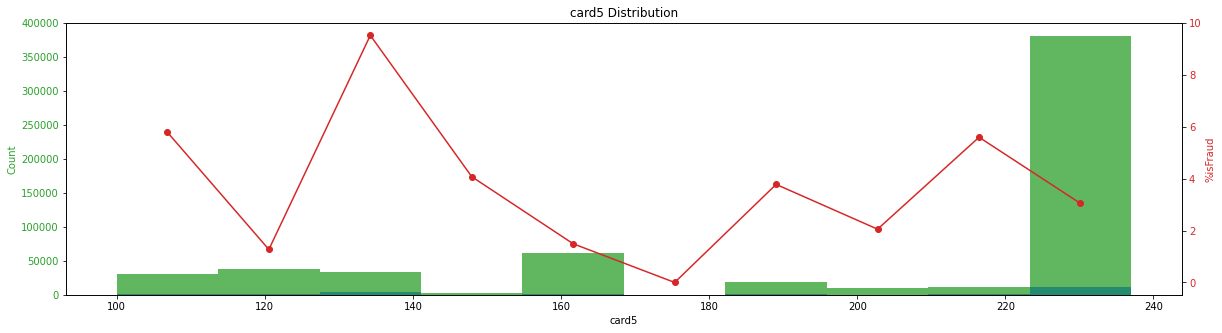

In [161]:
distribution_fraud_percent(df=train,
                           feature='card5',
                           target='isFraud',
                           bins=10)

### Addr Feature

In [139]:
addr_features = ['addr1', 'addr2']
train[addr_features].head()

,addr1,addr2
0,315.0,87.0
1,325.0,87.0
2,330.0,87.0
3,476.0,87.0
4,420.0,87.0


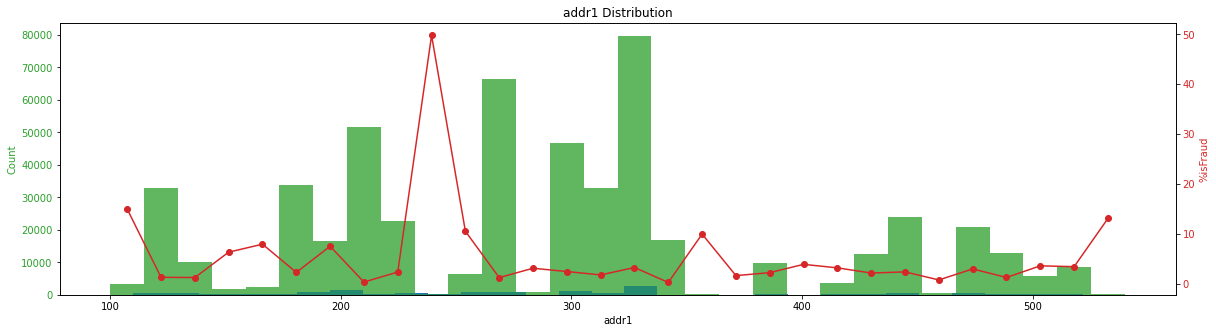

In [162]:
distribution_fraud_percent(df=train,
                           feature='addr1',
                           target='isFraud',
                           bins=30)

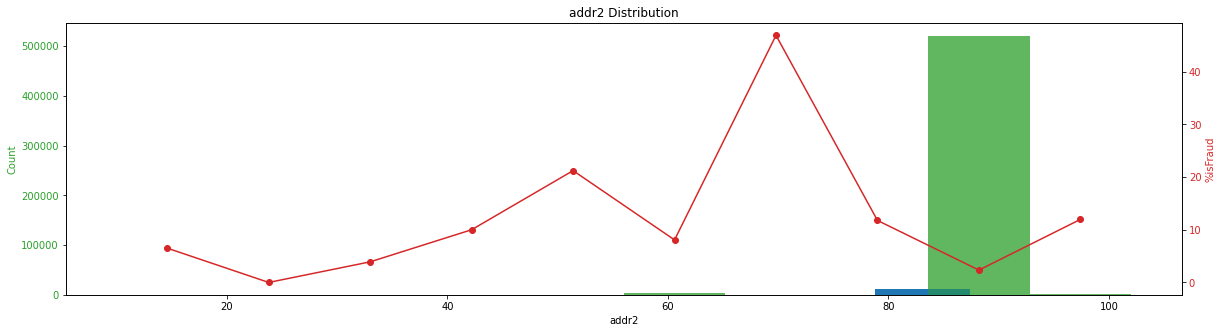

In [163]:
distribution_fraud_percent(df=train,
                           feature='addr2',
                           target='isFraud',
                           bins=10)

### Email Domain Feature

P_ and (R__) emaildomain: purchaser and recipient email domain

P_emaildomain
aim.com                315
anonymous.com        36998
aol.com              28289
att.net               4033
bellsouth.net         1909
cableone.net           159
centurylink.net        205
cfl.rr.com             172
charter.net            816
comcast.net           7888
cox.net               1393
earthlink.net          514
embarqmail.com         260
frontier.com           280
frontiernet.net        195
gmail                  496
gmail.com           228355
gmx.de                 149
hotmail.co.uk          112
hotmail.com          45250
hotmail.de              43
hotmail.es             305
hotmail.fr             295
icloud.com            6267
juno.com               322
live.com              3041
live.com.mx            749
live.fr                 56
mac.com                436
mail.com               559
me.com                1522
msn.com               4092
netzero.com            230
netzero.net            196
optonline.net         1011
outlook.com           5096
outlook.es    

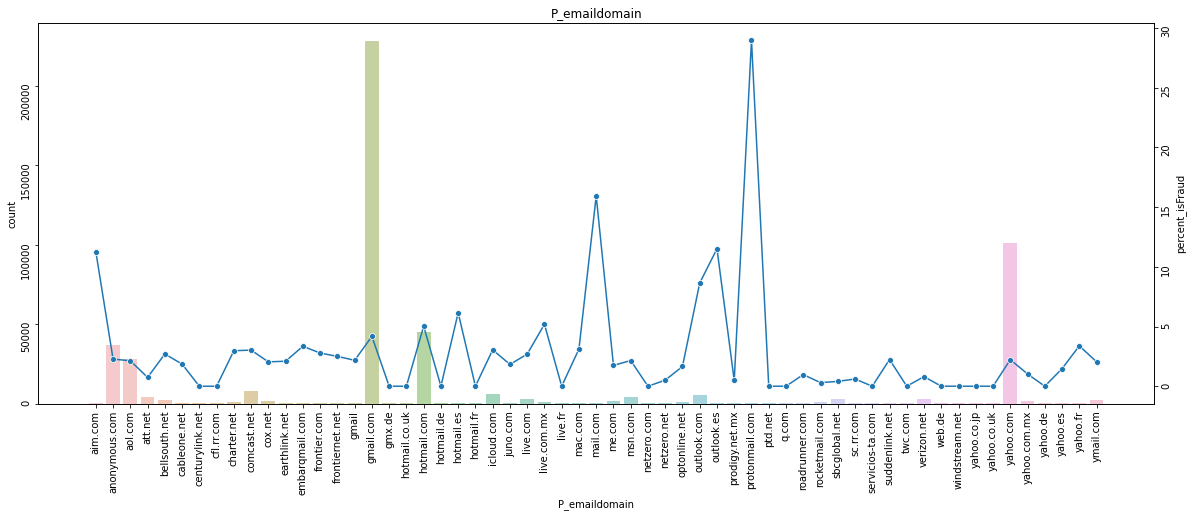

In [171]:
cat_fraud_percent(df=train, 
                  feature='P_emaildomain',
                  target='isFraud')

Some domains that have a small total size seem to have a higher chance of fraud

R_emaildomain
aim.com                36
anonymous.com       20529
aol.com              3701
att.net               430
bellsouth.net         422
cableone.net           27
centurylink.net        12
cfl.rr.com             37
charter.net           127
comcast.net          1812
cox.net               459
earthlink.net          79
embarqmail.com         68
frontier.com           52
frontiernet.net        14
gmail                  95
gmail.com           57147
gmx.de                147
hotmail.co.uk         105
hotmail.com         27509
hotmail.de             42
hotmail.es            292
hotmail.fr            293
icloud.com           1398
juno.com               53
live.com              762
live.com.mx           754
live.fr                55
mac.com               218
mail.com              122
me.com                556
msn.com               852
netzero.com            14
netzero.net             9
optonline.net         187
outlook.com          2507
outlook.es            433
prodigy.net.mx        20

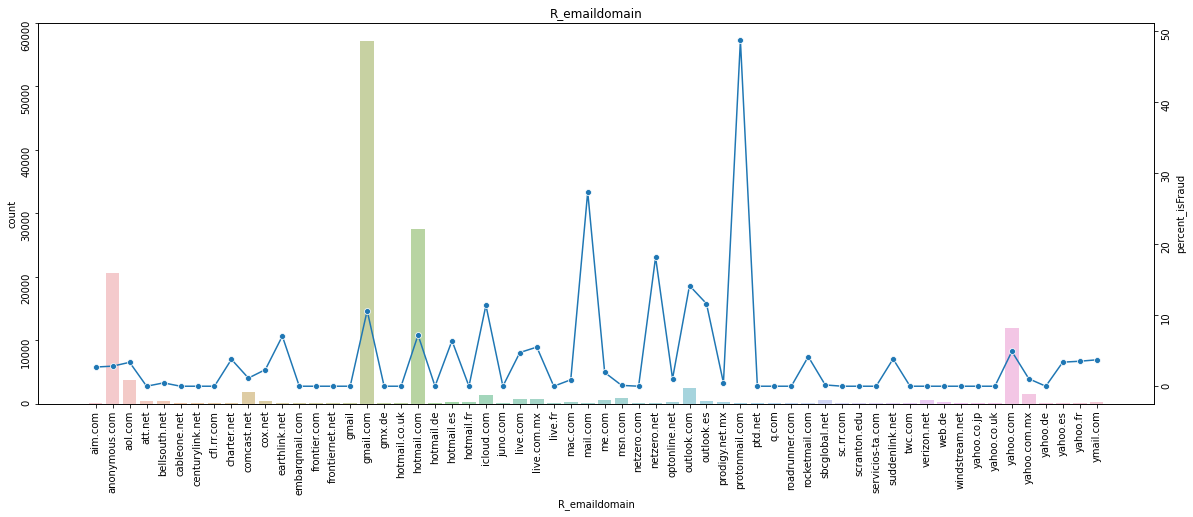

In [172]:
cat_fraud_percent(df=train, 
                  feature='R_emaildomain',
                  target='isFraud')

Some domains that have a small total size seem to have a higher chance of fraud

### Device Feature

In [144]:
device_feature = ['DeviceType', 'DeviceInfo']
train[device_feature].head()

,DeviceType,DeviceInfo
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,mobile,SAMSUNG SM-G892A Build/NRD90M


In [36]:
train.groupby('DeviceType', dropna=False).size()

DeviceType
desktop     85165
mobile      55645
NaN        449730
dtype: int64

DeviceType
desktop    85165
mobile     55645
dtype: int64


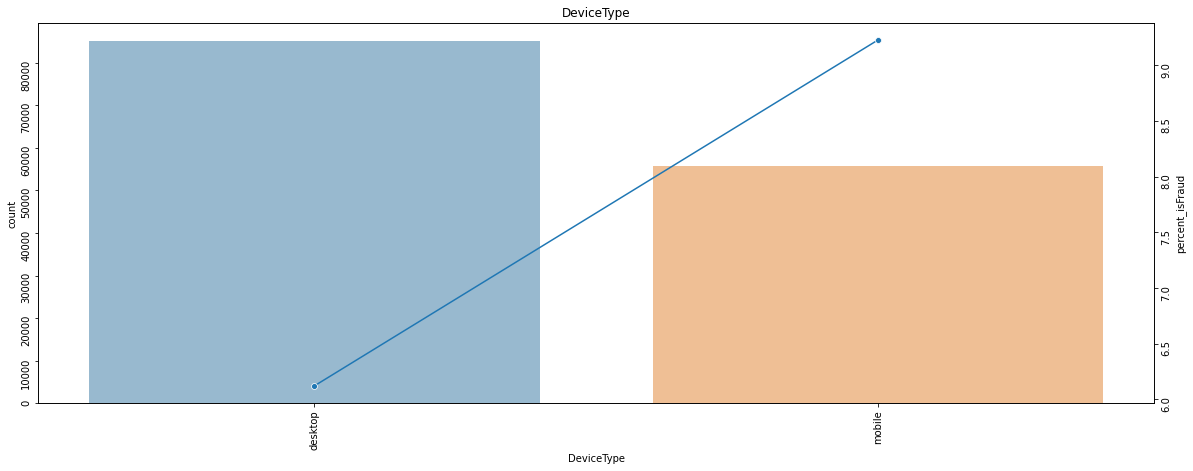

In [173]:
cat_fraud_percent(df=train, 
                  feature='DeviceType',
                  target='isFraud')

DeviceInfo
MacOS                    12573
SM-G531H Build/LMY48B      410
SM-G610M Build/MMB29K      461
SM-J700M Build/MMB29K      549
Trident/7.0               7440
Windows                  47722
iOS Device               19782
rv:11.0                   1901
rv:57.0                    962
rv:59.0                    362
dtype: int64


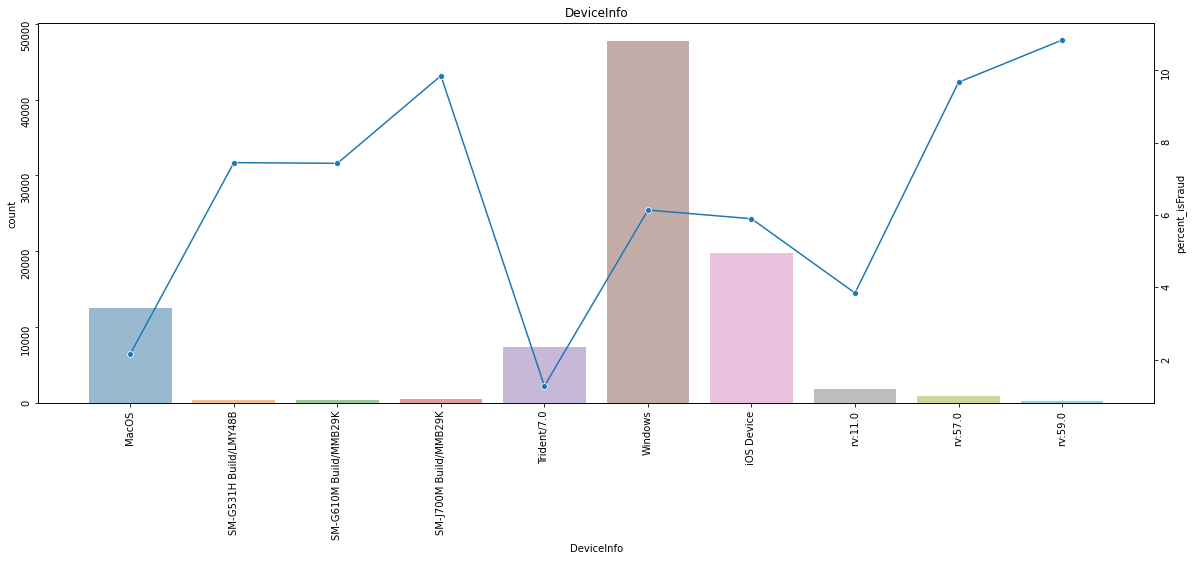

In [174]:
top_10_devices = train.groupby('DeviceInfo').size().sort_values(ascending=False)[:10]
top_10_devices = top_10_devices.reset_index()
top_10_devices = list(top_10_devices['DeviceInfo'])
#plot only the top 10 devices
cat_fraud_percent(df=train.loc[train['DeviceInfo'].isin(top_10_devices)], 
                  feature='DeviceInfo',
                  target='isFraud')

### Explor Time distribution of Test and Train Data

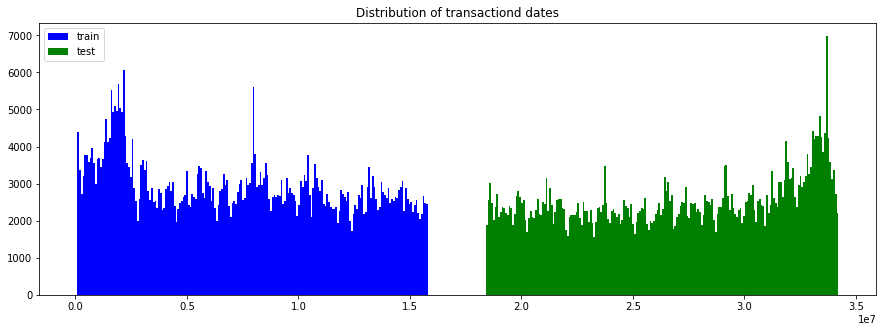

In [180]:
plt.figure(figsize=(15,5))
plt.hist(train['TransactionDT'], label='train', bins=200, color='blue');
plt.hist(test['TransactionDT'], label='test', bins=200, color='green');
plt.legend();
plt.title('Distribution of transactiond dates');
plt.show()

The train transaction datetime and the test transaction datetime do not overlap. Need to use time-based plit for validation. 
This was initially pointed out in the following kernel:  https://www.kaggle.com/robikscube/ieee-fraud-detection-first-look-and-eda

### ID Feature

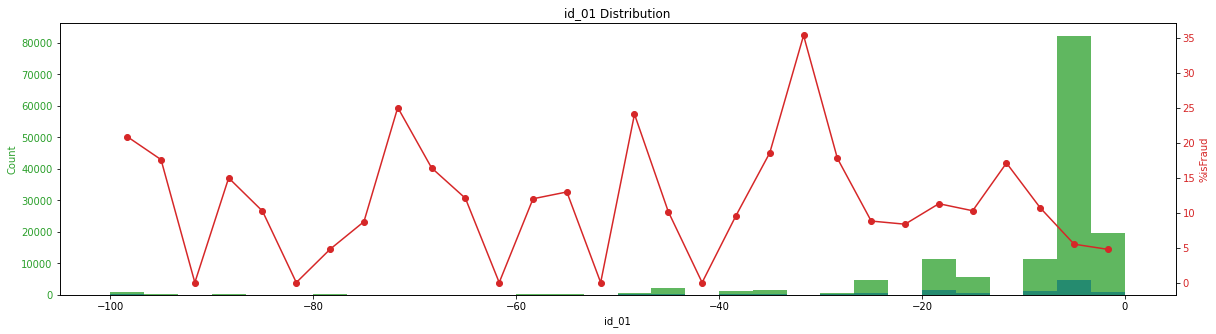

In [182]:
# id_01
distribution_fraud_percent(df=train,
                           feature='id_01',
                           target='isFraud',
                           bins=30)

In [183]:
# id_03
id_03_size = size_and_percentage(train, 'id_03')
print(id_03_size.head())

         size  percentage
id_03                    
NaN    524216   88.768923
0.0     63903   10.821113
1.0       863    0.146137
3.0       668    0.113117
2.0       421    0.071291


In [184]:
# id_11
id_11_size = size_and_percentage(train, 'id_11')
print(id_11_size.head())

              size  percentage
id_11                         
NaN         449562   76.127273
100.000000  133162   22.549192
95.080002     1231    0.208453
95.160004      754    0.127680
97.120003      440    0.074508


### V, D, C, M Feature Analysis

In [229]:
# list of useful features, will be updated based on analysis
features_to_use = []

#### V1-V11, D11 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 279287 Values ############### \
['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']

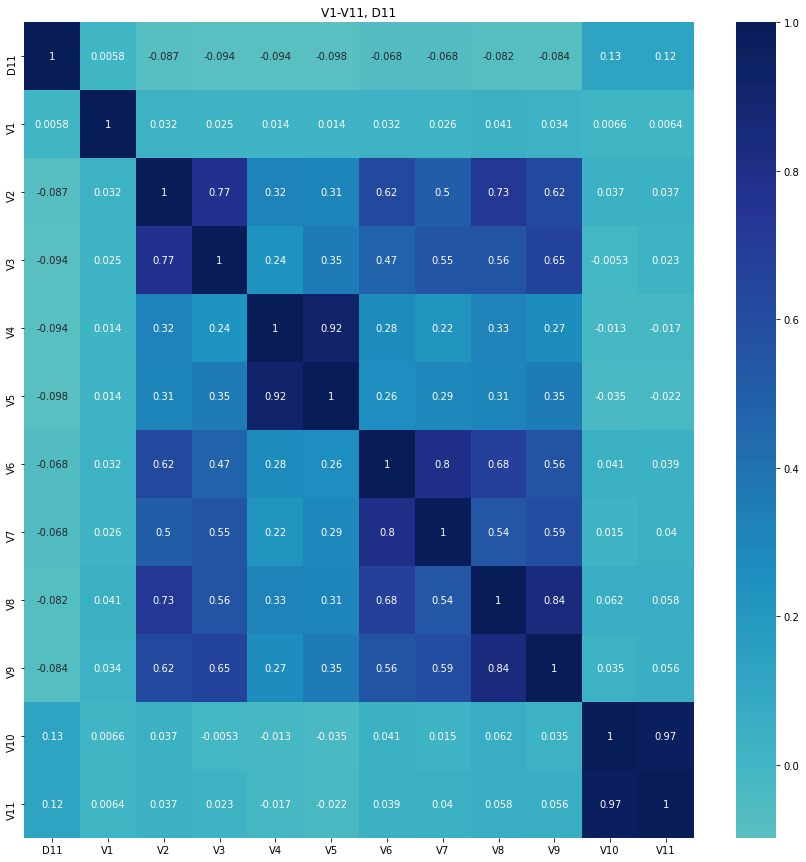

In [230]:
features = ['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']

corr_plot(features=features, title='V1-V11, D11')

Based off the correlation graph we can group highly correlated features:
1. V1
2. V2, V3
3. V4, V5
4. V6, V67
5. V8, V9
6. V10, V11
7. D11

In [231]:
groups = [['V1'],['V2','V3'],['V4','V5'],['V6','V7'],['V8','V9'],['V10','V11'], ['D11']]
use = reduce_groups(df=train, groups=groups)
print(f'Features to use: {use}')
for item in use:
    features_to_use.append(item)

Features to use: ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'D11']


#### V12-V34 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 76073 Values ############### \
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']

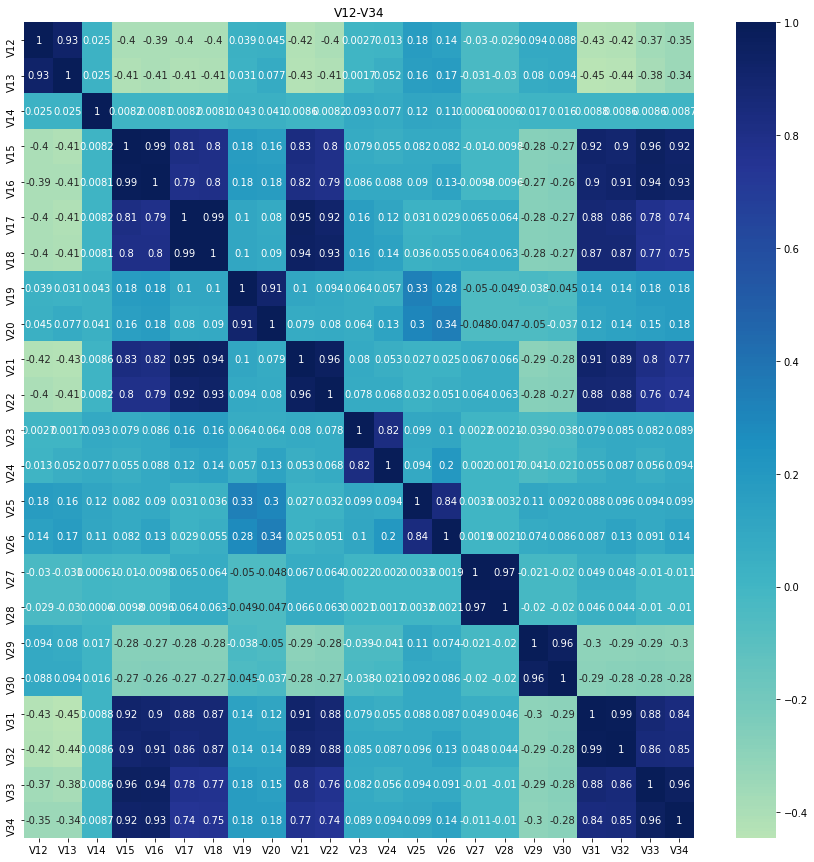

In [233]:
features = ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', \
            'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', \
            'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']

corr_plot(features=features, title='V12-V34')

Based off the correlation graph we can group highly correlated features:
1. V12, V13
2. V14
3. V15, V16, V17, V18, V21, V22, V31, V32, V33, V34
4. V19, V20
5. V23, V24
6. V25, V26
7. V27, V28
8. V29, V30

In [234]:
groups = [['V12', 'V13'],['V14'],['V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'], \
          ['V19', 'V20'],['V23', 'V24'],['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30']]
use = reduce_groups(df=train, groups=groups)
print(f'Features to use: {use}')
for item in use:
    features_to_use.append(item)

Features to use: ['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']


#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 168969 Values ############### \
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']










#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 77096 Values ############### \
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']

#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 89164 Values ############### \
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']

#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 314 Values ############### \
['V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137']

#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 508595 Values ############### \
['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163']
############### Missing 508589 Values ############### \
['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']

#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 450909 Values ############### \
['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']
############### Missing 450721 Values ############### \
['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']

#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 460110 Values ############### \
['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']
############### Missing 449124 Values ############### \
['V220', 'V221', 'V222', 'V227', 'V234', 'V238', 'V239', 'V245', 'V250', 'V251', 'V255', 'V256', 'V259', 'V270', 'V271', 'V272']

#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 12 Values ############### \
['V279', 'V280', 'V284', 'V285', 'V286', 'V287', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']

#### V35-V52 Analysis 
From the Nan analysis we can see that all of these features have the same amount of missing values. We will check value counts and correlation

############### Missing 508189 Values ############### \
['V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']

### Date Time Analysis

In [188]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

train['Weekdays'] = train['Date'].dt.dayofweek
train['Hours'] = train['Date'].dt.hour
train['Days'] = train['Date'].dt.day

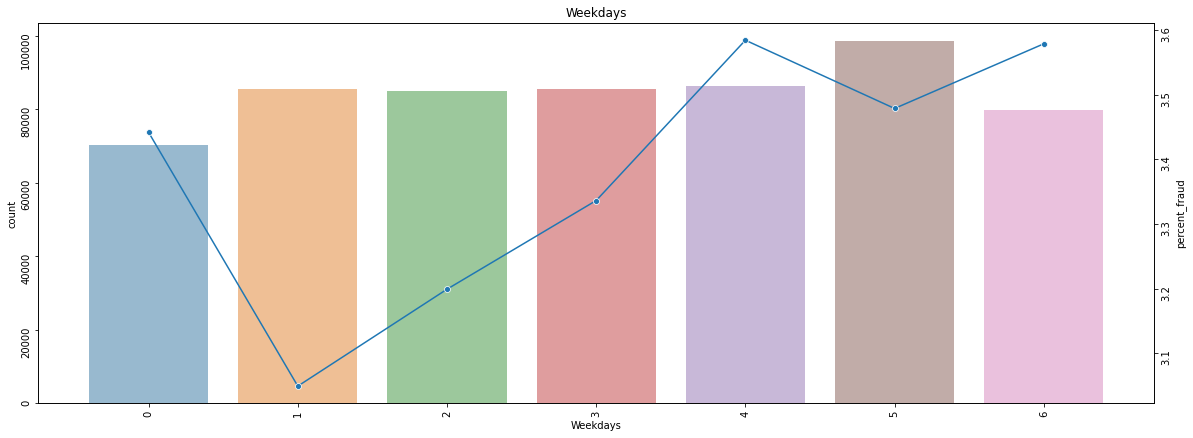

In [44]:
cat_fraud_percent(train, 'Weekdays')

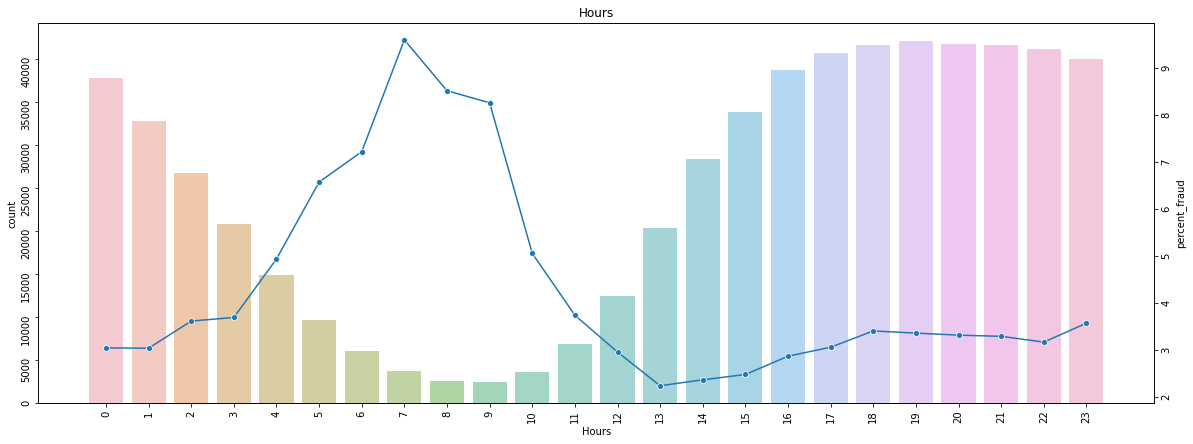

In [45]:
cat_fraud_percent(train, 'Hours')

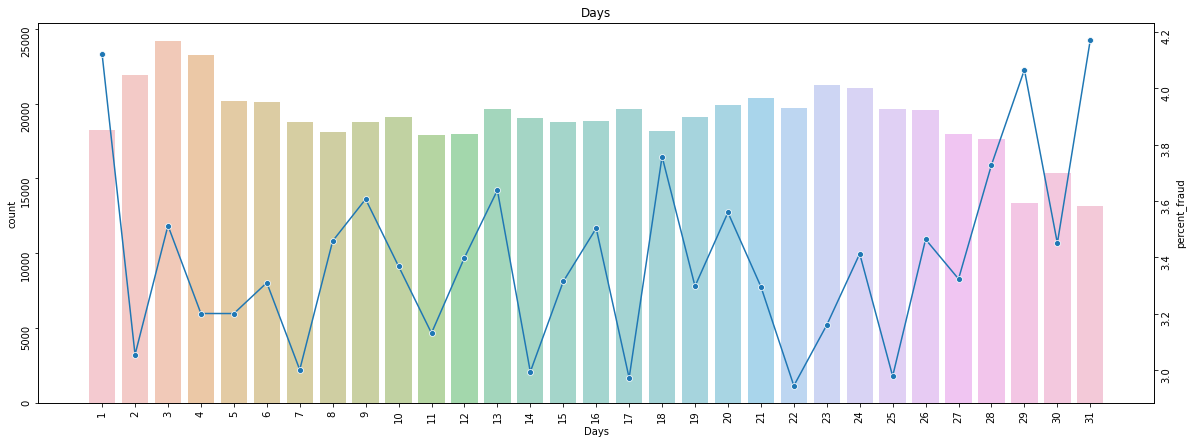

In [46]:
cat_fraud_percent(train, 'Days')